###Punto 2
##Laura Sofia Ortiz Arcos, Santiago Romero Lozano

Cargamos los datos y exportamos librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVC

from google.colab import drive, files
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.spatial import distance

from patsy import dmatrix

In [ ]:
dayBikes = pd.read_csv('day.csv')
dayBikes.info()
print("\n")
print("\n")
hourBikes = pd.read_csv('hour.csv')
hourBikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns 

In [ ]:
dayBikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
hourBikes.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


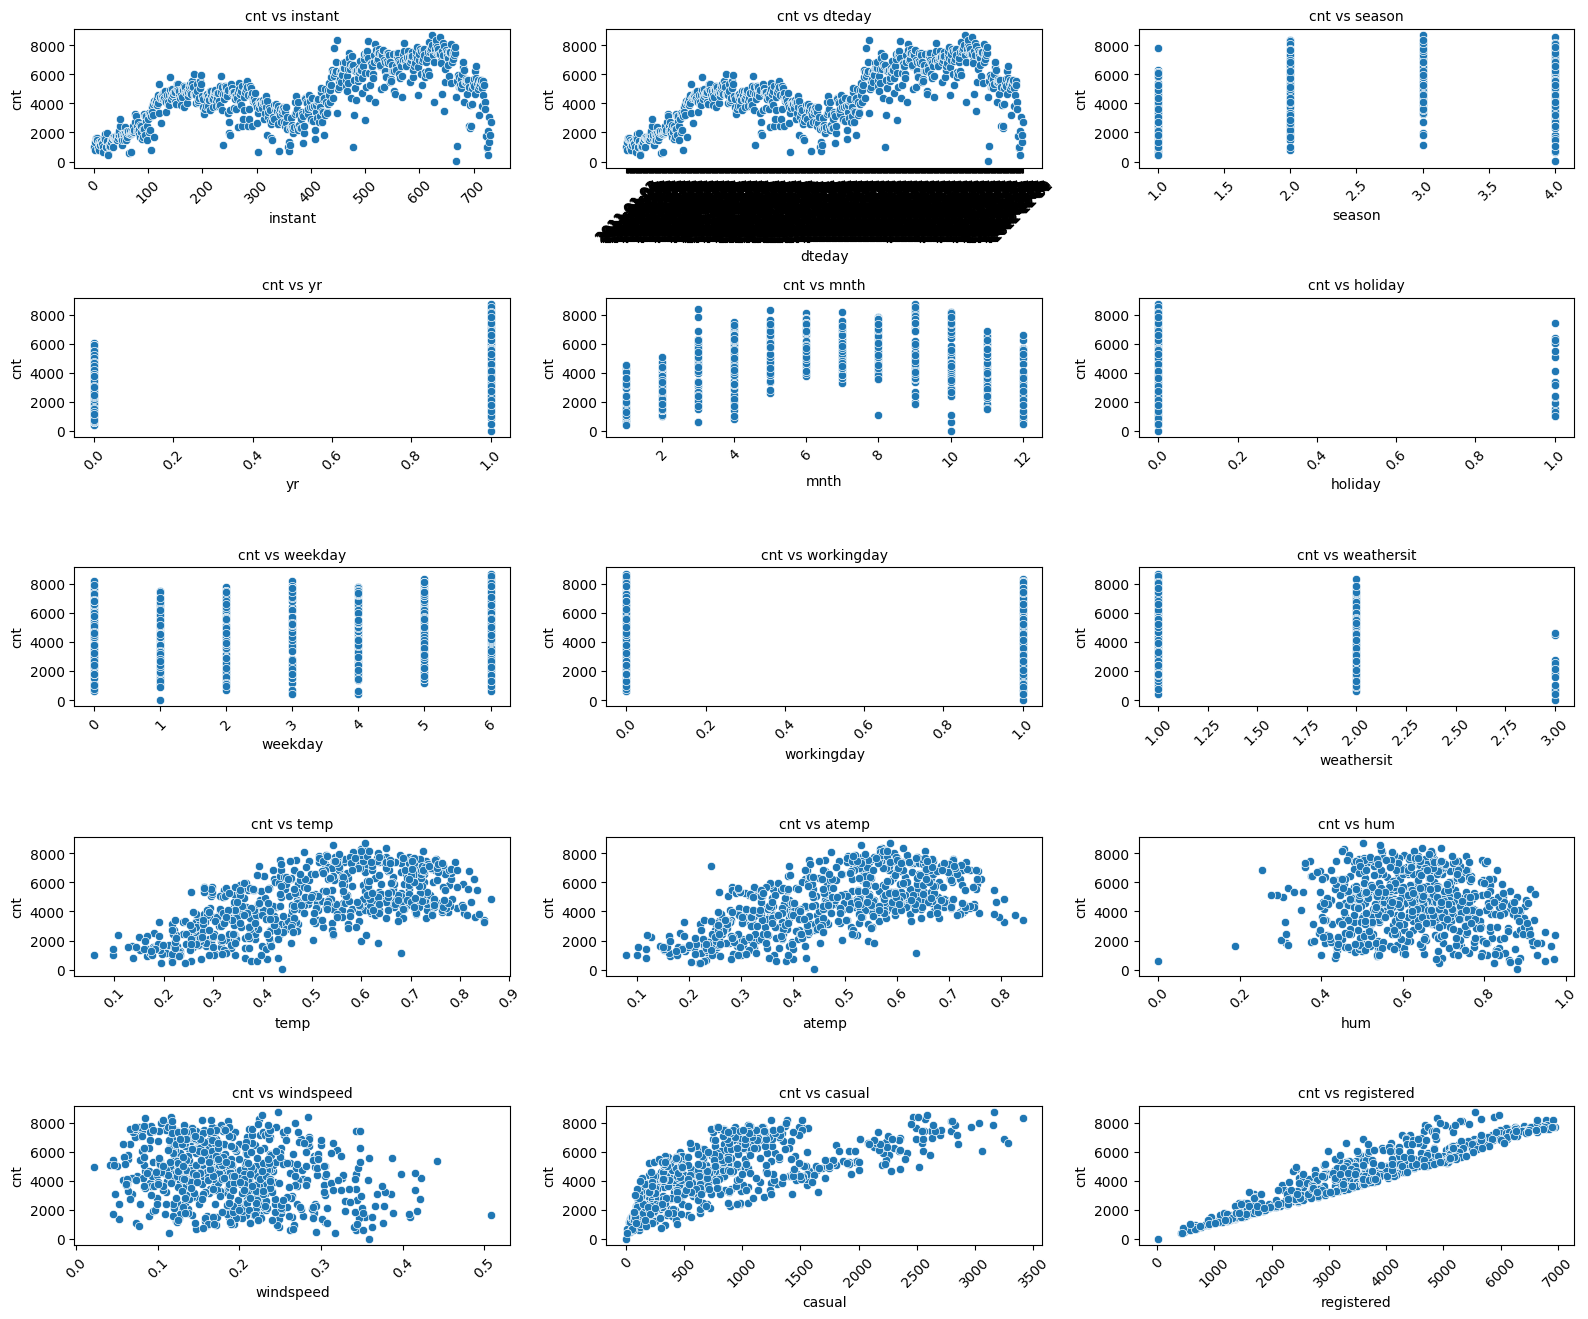

In [ ]:
columns_plot = [col for col in dayBikes.columns if col != 'cnt']

plt.figure(figsize=(16, 80))

for i, col in enumerate(columns_plot, start=1):
    plt.subplot(30, 3, i)
    sns.scatterplot(x=dayBikes[col], y=dayBikes['cnt'])
    plt.title(f'cnt vs {col}', fontsize=10)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

###Para el data base de day

Escogemos mnth, temp, atemp, hum, windspeed, casual y registered

Obviamos usar instant y dteday ya que al ser un instante y un dia no nos puede dar mucha información.

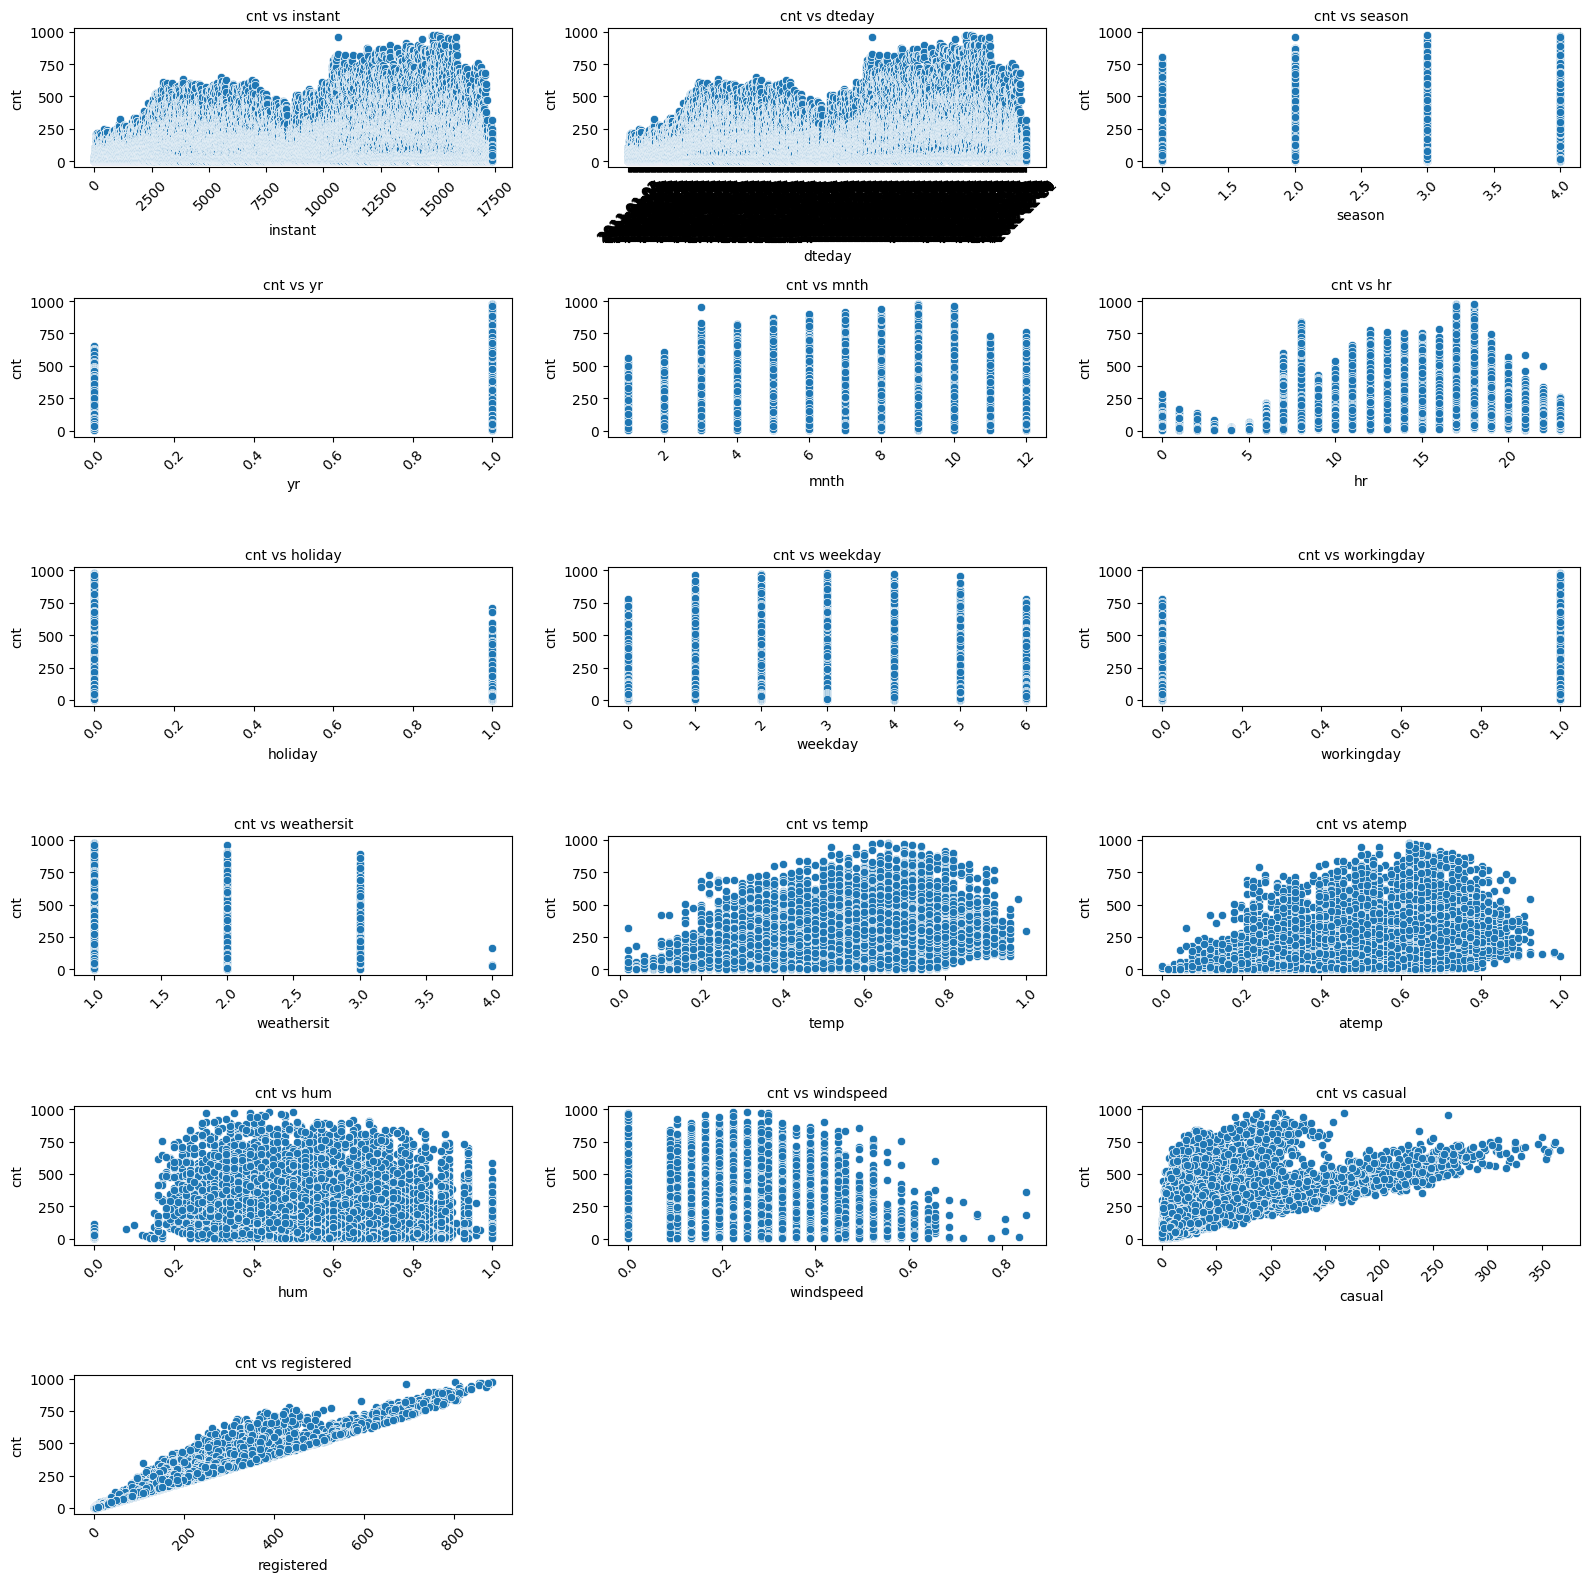

In [ ]:
columns_plot = [col for col in hourBikes.columns if col != 'cnt']

plt.figure(figsize=(16, 80))

for i, col in enumerate(columns_plot, start=1):
    plt.subplot(30, 3, i)
    sns.scatterplot(x=hourBikes[col], y=hourBikes['cnt'])
    plt.title(f'cnt vs {col}', fontsize=10)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

###Para el data base de hr

Escogemos hr ya que las otras ya se usan y deben estar muy correlacionadas por el hecho de que a las 24 horas se cumplen las de un dia

###Despues de escoger los datos

Vamos a separar nuestros datos y prepararlos para entrenamiento

In [ ]:

# Define the features you want to use
UsedDataDay = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered','cnt']
UsedDataHour = ['hr','temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered','cnt']

# Create cleaned dataframes
dataCleanedDay = dayBikes[UsedDataDay]
dataCleanedHour = hourBikes[UsedDataHour]

# Prepare data for training Day
x = dataCleanedDay.drop(columns=['cnt'])
y = dataCleanedDay['cnt']
X_trainDay, X_testDay, y_trainDay, y_testDay = train_test_split(x, y, test_size=0.2, random_state=42)


# Prepare data for training Day
x = dataCleanedHour.drop(columns=['cnt'])
y = dataCleanedHour['cnt']
X_trainHour, X_testHour, y_trainHour, y_testHour = train_test_split(x, y, test_size=0.2, random_state=42)

# Standardize features
'''scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_trainDay)
X_test_scaled = scaler.transform(X_testDay)
'''

'scaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_trainDay)\nX_test_scaled = scaler.transform(X_testDay)\n'

Empleamos los modelos de kernel y tambien creamos funciones de Knn, primero vamos a usar la basica pero luego usaremos distintas

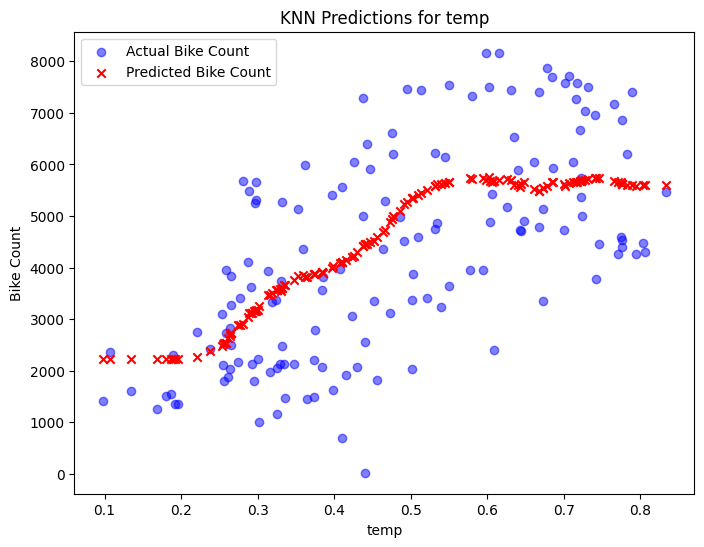

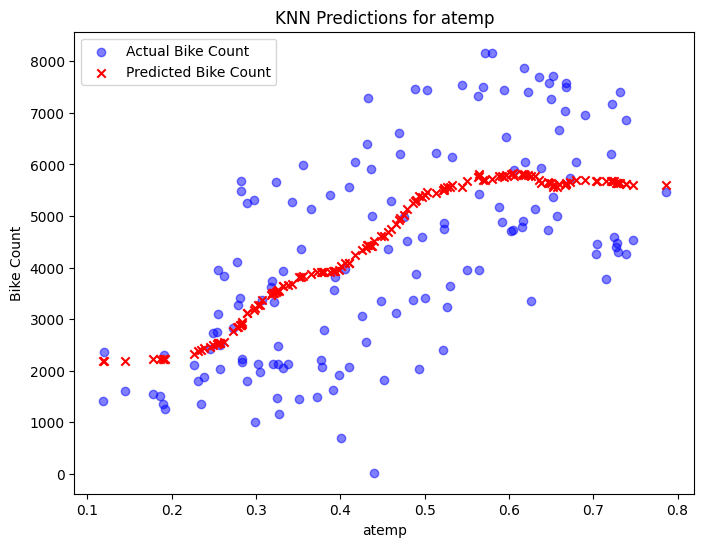

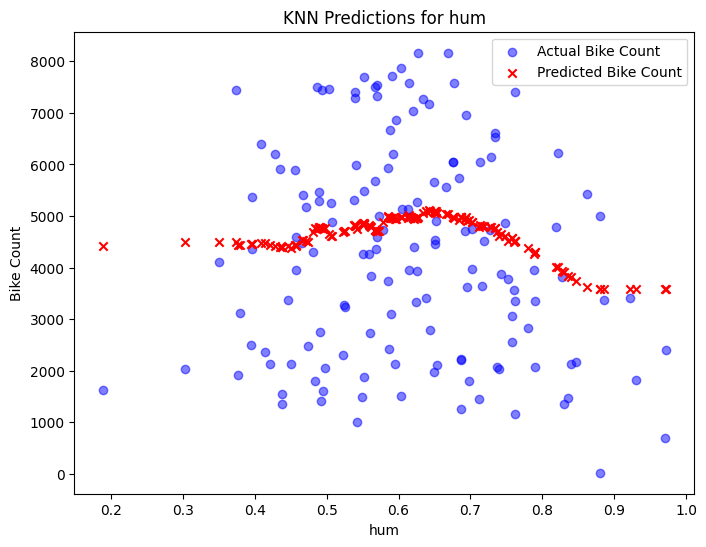

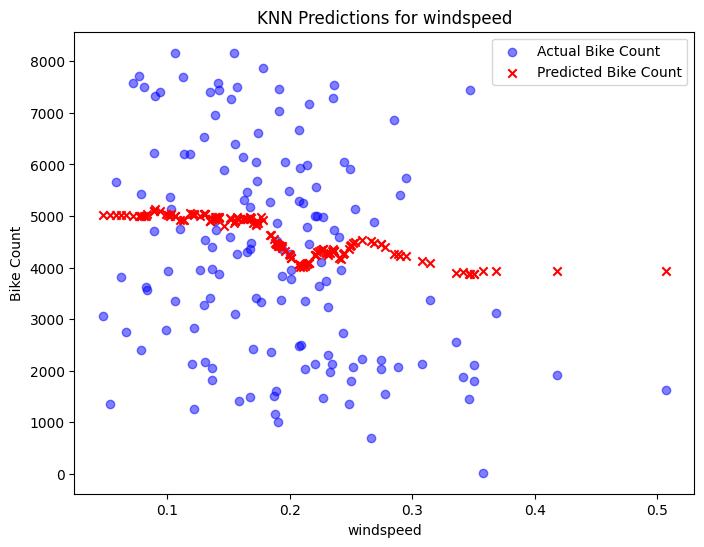

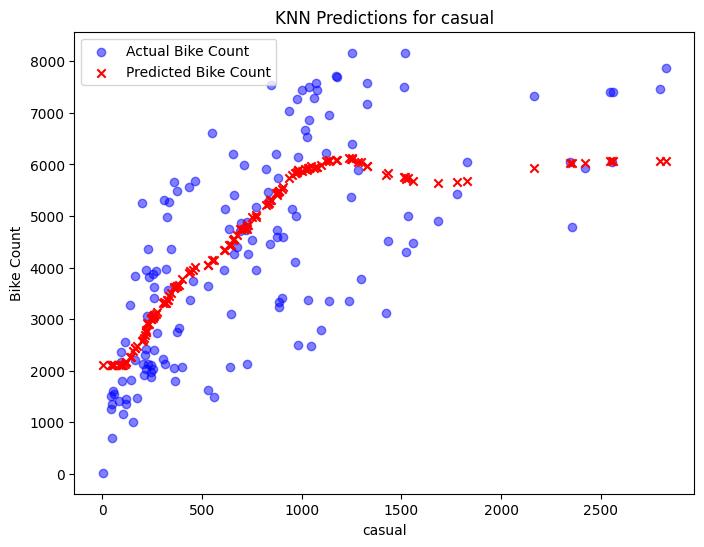

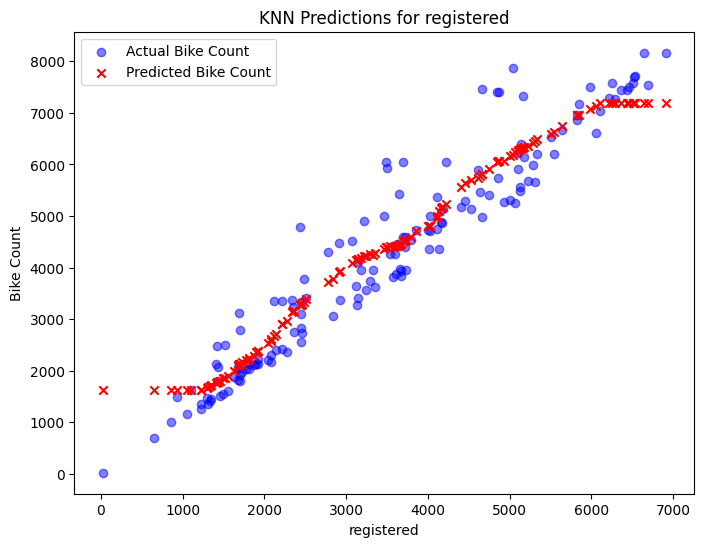

In [ ]:
def knn_basic(k: int, point:float,data_x:np.ndarray,data_y:np.ndarray) -> float:
    idx_sorted = np.argsort((data_x-point)*(data_x-point))[:k]
    return data_y[idx_sorted].mean()

# Set the value of k
k_value = 100

# Iterate over all features and calculate predictions
for feature in X_trainDay.columns:
    test_points = X_testDay[feature].values
    predicted_counts = [knn_basic(k_value, point, X_trainDay[feature].values, y_trainDay.values) for point in test_points]

    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(test_points, y_testDay, label='Actual Bike Count', color='b', alpha=0.5)
    plt.scatter(test_points, predicted_counts, label='Predicted Bike Count', color='r', marker='x')
    plt.xlabel(feature)
    plt.ylabel('Bike Count')
    plt.title(f'KNN Predictions for {feature}')
    plt.legend()
    plt.show()


si escogemos solo uno, por ejemplo temperatura podemos jugar con los kernels y asi entender el comportamiento cuando los valores de K cambian

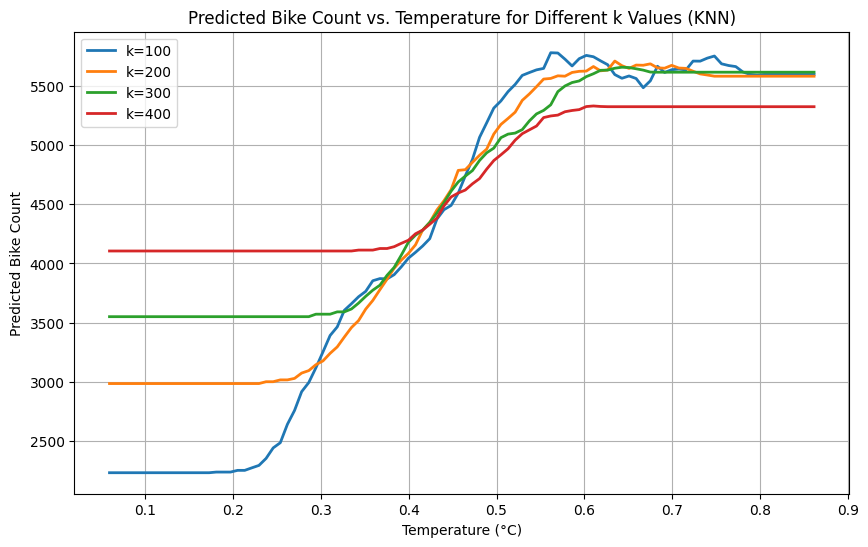

In [ ]:
# Vary the value of k
k_values = [100, 200, 300, 400]

temperature_values = np.linspace(X_trainDay['temp'].min(), X_trainDay['temp'].max(), 100)  # Generate temperature values

# Calculate predictions for each k value at different temperatures
predicted_counts = []
for k_value in k_values:
    predicted_counts_k = []
    for temp_value in temperature_values:
        predicted_count = knn_basic(k_value, temp_value, X_trainDay['temp'].values, y_trainDay.values)
        predicted_counts_k.append(predicted_count)
    predicted_counts.append(predicted_counts_k)

# Create a plot
plt.figure(figsize=(10, 6))
for i, k_value in enumerate(k_values):
    plt.plot(temperature_values, predicted_counts[i], label=f'k={k_value}', linewidth=2)

plt.xlabel('Temperature (°C)')
plt.ylabel('Predicted Bike Count')
plt.title('Predicted Bike Count vs. Temperature for Different k Values (KNN)')
plt.legend()
plt.grid(True)
plt.show()


Ahora podemos emplear diferentes funciones de kernel para probar en especifico dos columnas

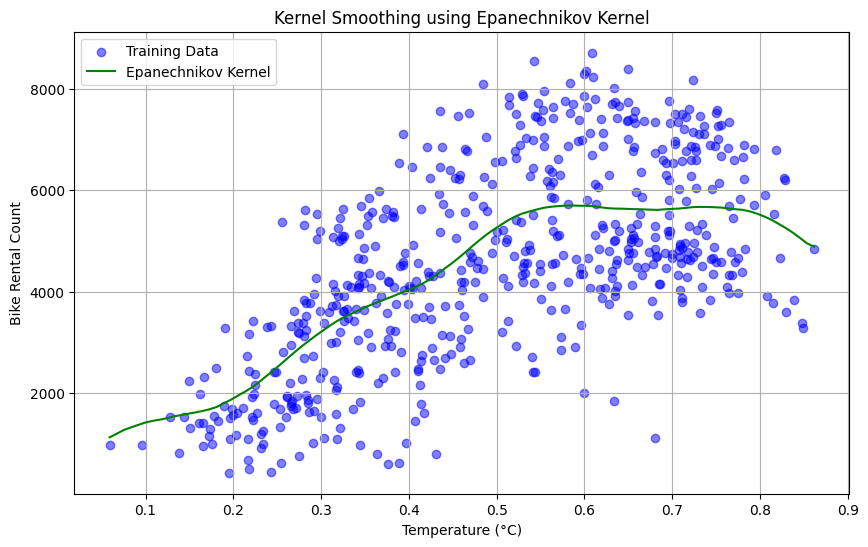

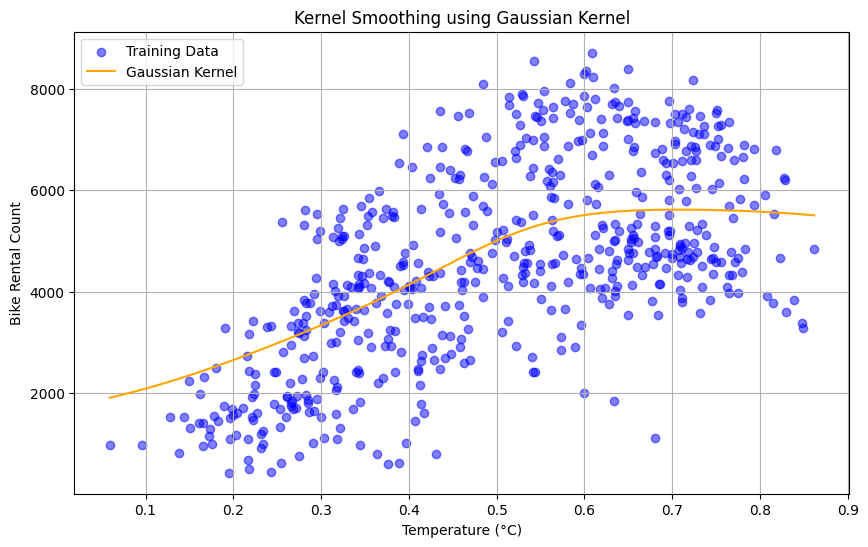

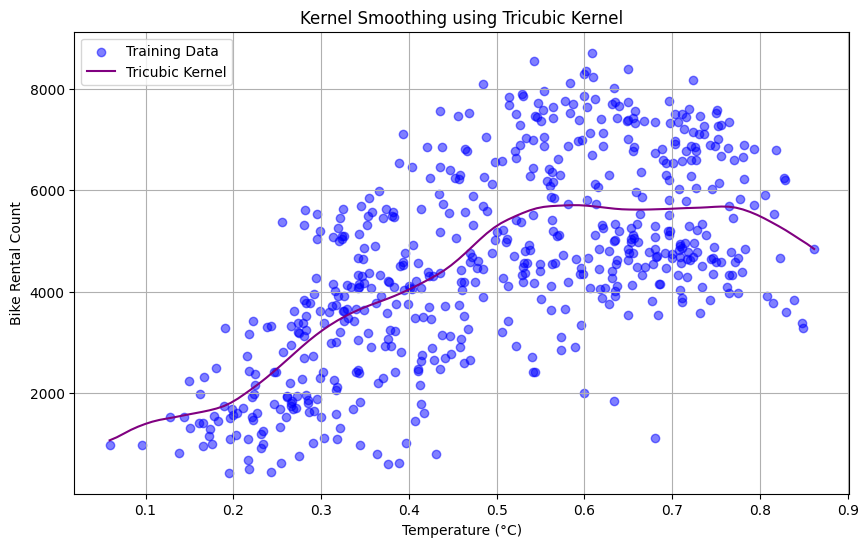

In [ ]:
# Creamos una función para Epanechnikov
def knn_Epanechnikov(lmbda: float, point: np.ndarray, data_x: np.ndarray, data_y: np.ndarray) -> np.ndarray:
    t = np.absolute(data_x - point) / np.float64(lmbda)
    k = np.where(t <= 1, 0.75 * (1 - t), 0)
    return (k @ data_y) / k.sum()

# Función de suavizado con kernel Gaussiano
def knn_Gaussian(lmbda: float, point: np.ndarray, data_x: np.ndarray, data_y: np.ndarray) -> np.ndarray:
    t = np.absolute(data_x - point) / lmbda
    k = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * t**2)
    if np.isnan(k).any() or np.isnan(data_y).any():
        return np.zeros_like(data_y)
    return (k @ data_y) / (k.sum())

# Función de suavizado con kernel Tricúbico
def knn_Tricubic(lmbda: float, point: np.ndarray, data_x: np.ndarray, data_y: np.ndarray) -> np.ndarray:
    t = np.absolute(data_x - point) / lmbda
    k = np.where(t <= 1, (1 - t**3)**3, 0)
    return (k @ data_y) / k.sum()

lmbda = 0.1

# Create an array of temperature values for prediction
temp_values = np.linspace(X_trainDay['temp'].min(), X_trainDay['temp'].max(), 100).reshape(-1, 1)

# Predict using Epanechnikov kernel
y_pred_epanechnikov = np.array([knn_Epanechnikov(lmbda, point, X_trainDay['temp'], y_trainDay) for point in temp_values])

# Plot Epanechnikov kernel
plt.figure(figsize=(10, 6))
plt.scatter(X_trainDay['temp'], y_trainDay, label='Training Data', color='blue', alpha=0.5)
plt.plot(temp_values, y_pred_epanechnikov, label='Epanechnikov Kernel', color='green')
plt.xlabel('Temperature (°C)')
plt.ylabel('Bike Rental Count')
plt.title('Kernel Smoothing using Epanechnikov Kernel')
plt.legend()
plt.grid(True)
plt.show()

print("\n")

# Predict using Gaussian kernel
y_pred_gaussian = np.array([knn_Gaussian(lmbda, point, X_trainDay['temp'], y_trainDay) for point in temp_values])

# Plot Gaussian kernel
plt.figure(figsize=(10, 6))
plt.scatter(X_trainDay['temp'], y_trainDay, label='Training Data', color='blue', alpha=0.5)
plt.plot(temp_values, y_pred_gaussian, label='Gaussian Kernel', color='orange')
plt.xlabel('Temperature (°C)')
plt.ylabel('Bike Rental Count')
plt.title('Kernel Smoothing using Gaussian Kernel')
plt.legend()
plt.grid(True)
plt.show()

print("\n")

# Predict using Tricubic kernel
y_pred_tricubic = np.array([knn_Tricubic(lmbda, point, X_trainDay['temp'], y_trainDay) for point in temp_values])

# Plot Tricubic kernel
plt.figure(figsize=(10, 6))
plt.scatter(X_trainDay['temp'], y_trainDay, label='Training Data', color='blue', alpha=0.5)
plt.plot(temp_values, y_pred_tricubic, label='Tricubic Kernel', color='purple')
plt.xlabel('Temperature (°C)')
plt.ylabel('Bike Rental Count')
plt.title('Kernel Smoothing using Tricubic Kernel')
plt.legend()
plt.grid(True)
plt.show()

Dado que la epanechnikov muestra ser el mejor modelo vamos a usarlos con otras variables

In [ ]:
def desnormalize_min_max(X_norm, X_min, X_max):
    return X_norm * (X_max - X_min) + X_min

print(desnormalize_min_max(.4,-8,36))

y_pred_epanechnikov_value = np.array(knn_Epanechnikov(lmbda, .4, X_trainDay['temp'], y_trainDay))
print(y_pred_epanechnikov_value)



9.600000000000001
4041.1411674879528


Usando la función desnormalize_min_max podemos saber que temperatura estamos tomando dentro de nuestros datos normalizados

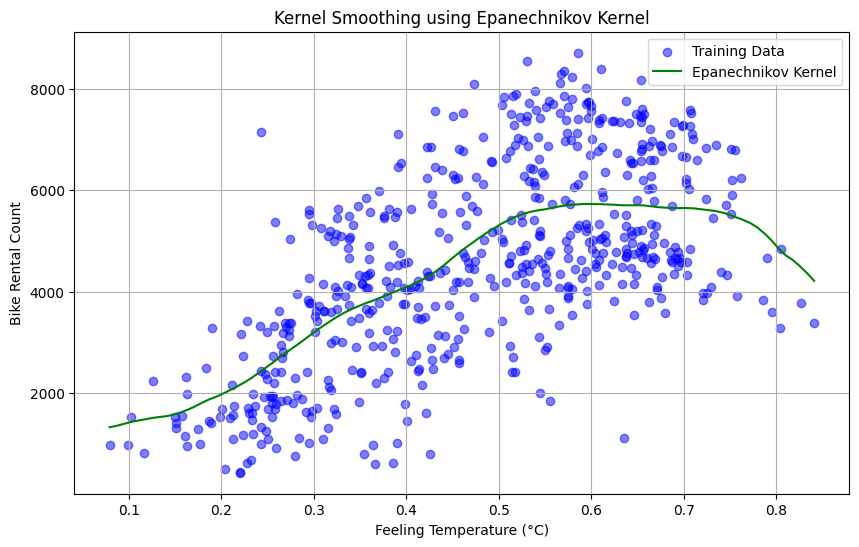

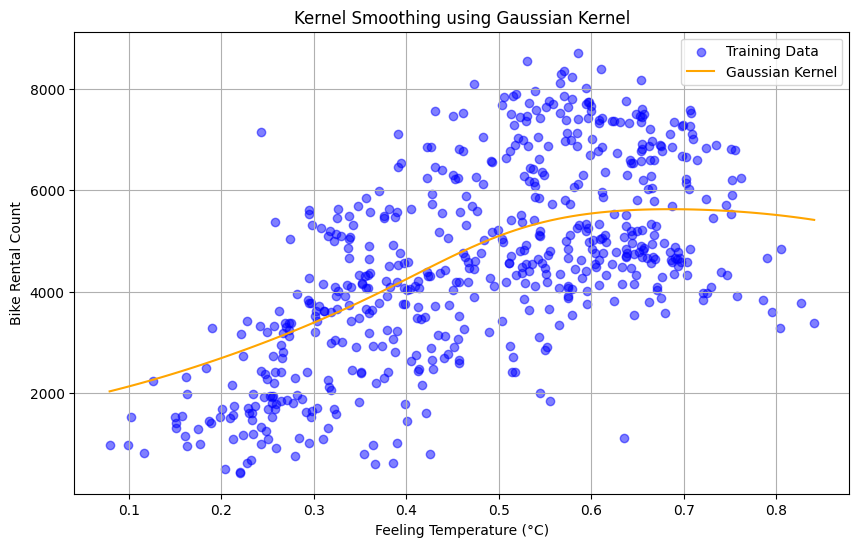

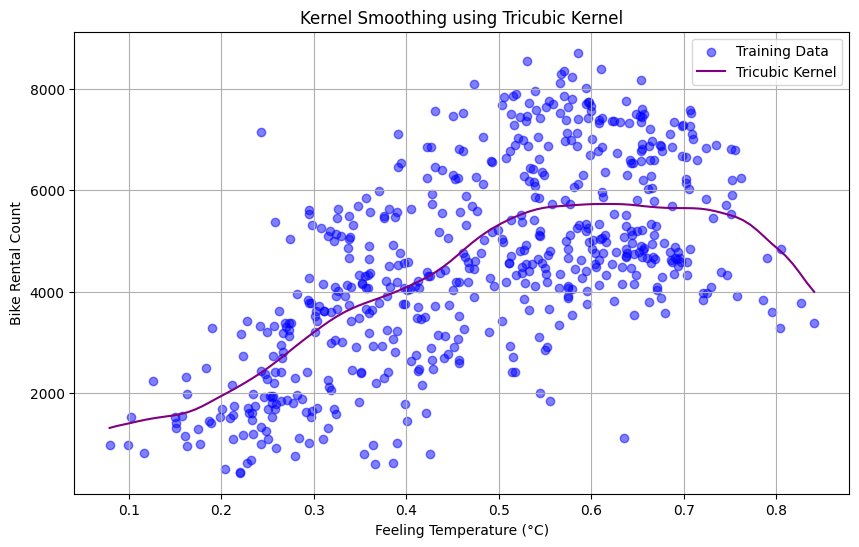

In [ ]:
lmbda = 0.1

# Create an array of temperature values for prediction
temp_values = np.linspace(X_trainDay['atemp'].min(), X_trainDay['atemp'].max(), 100).reshape(-1, 1)

# Predict using Epanechnikov kernel
y_pred_epanechnikov = np.array([knn_Epanechnikov(lmbda, point, X_trainDay['atemp'], y_trainDay) for point in temp_values])

# Plot Epanechnikov kernel
plt.figure(figsize=(10, 6))
plt.scatter(X_trainDay['atemp'], y_trainDay, label='Training Data', color='blue', alpha=0.5)
plt.plot(temp_values, y_pred_epanechnikov, label='Epanechnikov Kernel', color='green')
plt.xlabel('Feeling Temperature (°C)')
plt.ylabel('Bike Rental Count')
plt.title('Kernel Smoothing using Epanechnikov Kernel')
plt.legend()
plt.grid(True)
plt.show()

print("\n")

# Predict using Gaussian kernel
y_pred_gaussian = np.array([knn_Gaussian(lmbda, point, X_trainDay['atemp'], y_trainDay) for point in temp_values])

# Plot Gaussian kernel
plt.figure(figsize=(10, 6))
plt.scatter(X_trainDay['atemp'], y_trainDay, label='Training Data', color='blue', alpha=0.5)
plt.plot(temp_values, y_pred_gaussian, label='Gaussian Kernel', color='orange')
plt.xlabel('Feeling Temperature (°C)')
plt.ylabel('Bike Rental Count')
plt.title('Kernel Smoothing using Gaussian Kernel')
plt.legend()
plt.grid(True)
plt.show()

print("\n")

# Predict using Tricubic kernel
y_pred_tricubic = np.array([knn_Tricubic(lmbda, point, X_trainDay['atemp'], y_trainDay) for point in temp_values])

# Plot Tricubic kernel
plt.figure(figsize=(10, 6))
plt.scatter(X_trainDay['atemp'], y_trainDay, label='Training Data', color='blue', alpha=0.5)
plt.plot(temp_values, y_pred_tricubic, label='Tricubic Kernel', color='purple')
plt.xlabel('Feeling Temperature (°C)')
plt.ylabel('Bike Rental Count')
plt.title('Kernel Smoothing using Tricubic Kernel')
plt.legend()
plt.grid(True)
plt.show()

Usamos la tricubica ya que explica bien los datos

In [ ]:
def desnormalize_min_max(X_norm, X_min, X_max):
    return X_norm * (X_max - X_min) + X_min

print(desnormalize_min_max(.4,-16,50))

y_pred_tricubic_value = np.array(knn_Tricubic(lmbda, .7, X_trainDay['atemp'], y_trainDay))
print(y_pred_tricubic_value)



10.400000000000002
5649.515836772758


<ipython-input-10-6126b2e3a7ad>:5: RuntimeWarning: invalid value encountered in scalar divide
  return (k @ data_y) / k.sum()


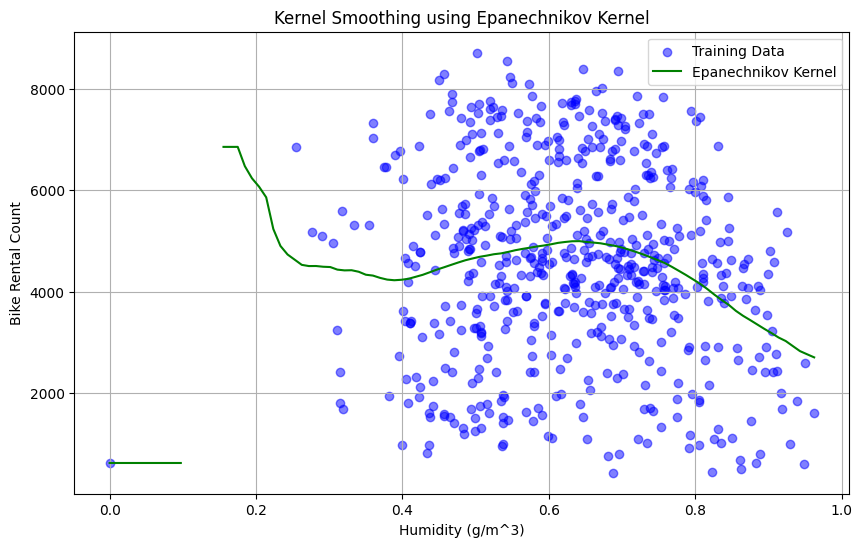

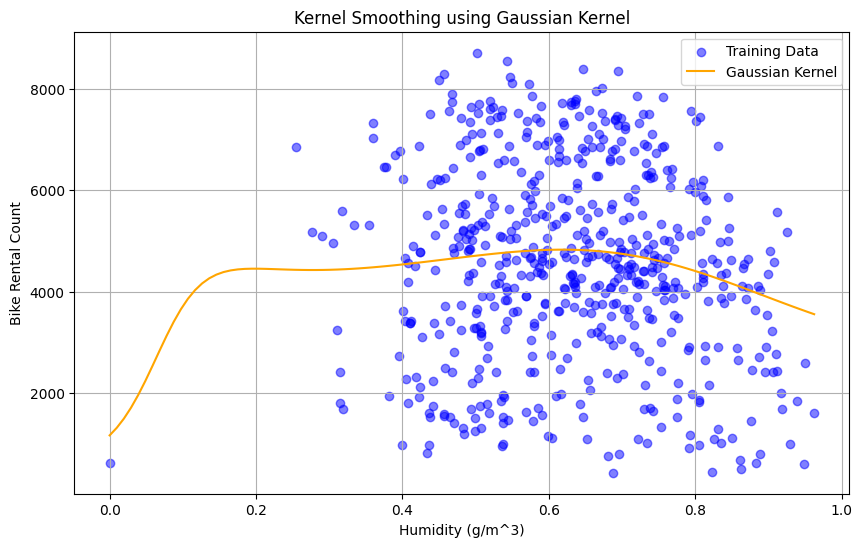

<ipython-input-10-6126b2e3a7ad>:19: RuntimeWarning: invalid value encountered in scalar divide
  return (k @ data_y) / k.sum()


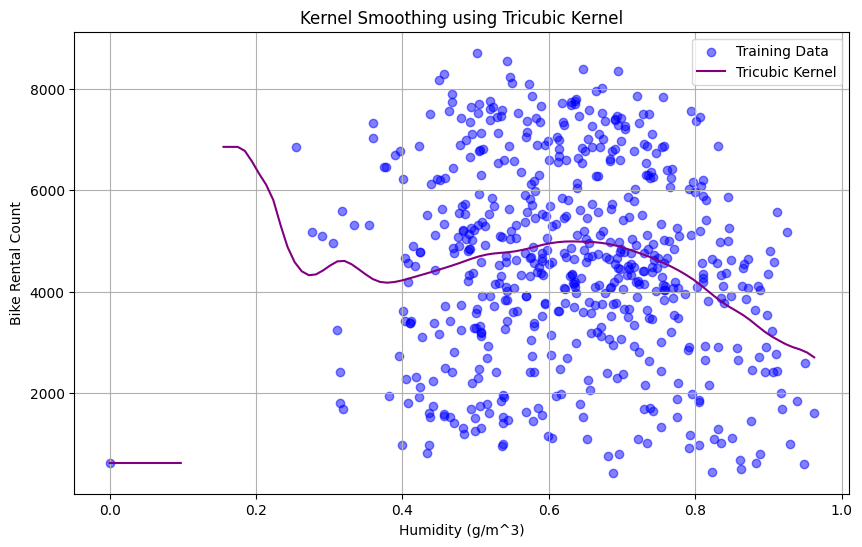

In [ ]:
lmbda =0.1

# Create an array of temperature values for prediction
temp_values = np.linspace(X_trainDay['hum'].min(), X_trainDay['hum'].max(), 100).reshape(-1, 1)

# Predict using Epanechnikov kernel
y_pred_epanechnikov = np.array([knn_Epanechnikov(lmbda, point, X_trainDay['hum'], y_trainDay) for point in temp_values])

# Plot Epanechnikov kernel
plt.figure(figsize=(10, 6))
plt.scatter(X_trainDay['hum'], y_trainDay, label='Training Data', color='blue', alpha=0.5)
plt.plot(temp_values, y_pred_epanechnikov, label='Epanechnikov Kernel', color='green')
plt.xlabel('Humidity (g/m^3)')
plt.ylabel('Bike Rental Count')
plt.title('Kernel Smoothing using Epanechnikov Kernel')
plt.legend()
plt.grid(True)
plt.show()

print("\n")

# Predict using Gaussian kernel
y_pred_gaussian = np.array([knn_Gaussian(lmbda, point, X_trainDay['hum'], y_trainDay) for point in temp_values])

# Plot Gaussian kernel
plt.figure(figsize=(10, 6))
plt.scatter(X_trainDay['hum'], y_trainDay, label='Training Data', color='blue', alpha=0.5)
plt.plot(temp_values, y_pred_gaussian, label='Gaussian Kernel', color='orange')
plt.xlabel('Humidity (g/m^3)')
plt.ylabel('Bike Rental Count')
plt.title('Kernel Smoothing using Gaussian Kernel')
plt.legend()
plt.grid(True)
plt.show()

print("\n")

# Predict using Tricubic kernel
y_pred_tricubic = np.array([knn_Tricubic(lmbda, point, X_trainDay['hum'], y_trainDay) for point in temp_values])

# Plot Tricubic kernel
plt.figure(figsize=(10, 6))
plt.scatter(X_trainDay['hum'], y_trainDay, label='Training Data', color='blue', alpha=0.5)
plt.plot(temp_values, y_pred_tricubic, label='Tricubic Kernel', color='purple')
plt.xlabel('Humidity (g/m^3)')
plt.ylabel('Bike Rental Count')
plt.title('Kernel Smoothing using Tricubic Kernel')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(0.5*100)

y_pred_gaussian_value = np.array(knn_Gaussian(lmbda, 0.5, X_trainDay['hum'], y_trainDay))
print(y_pred_gaussian_value)

50.0
4709.824528136784


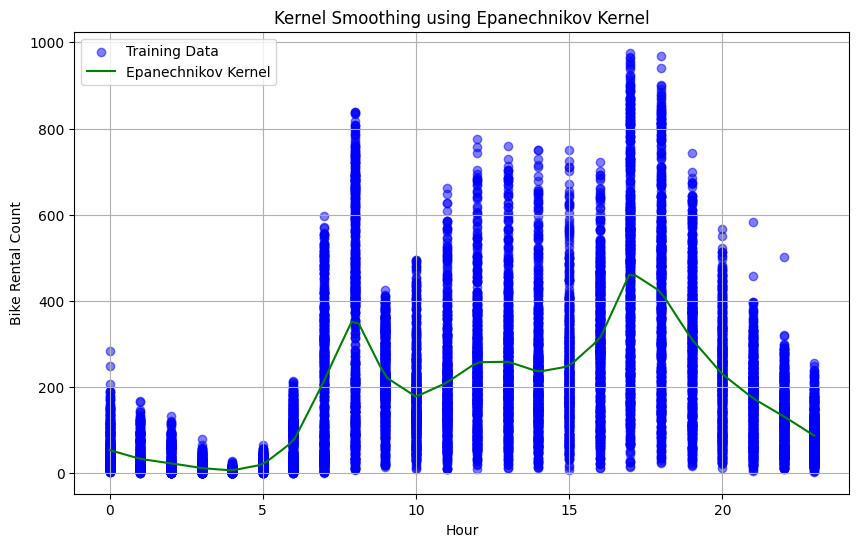

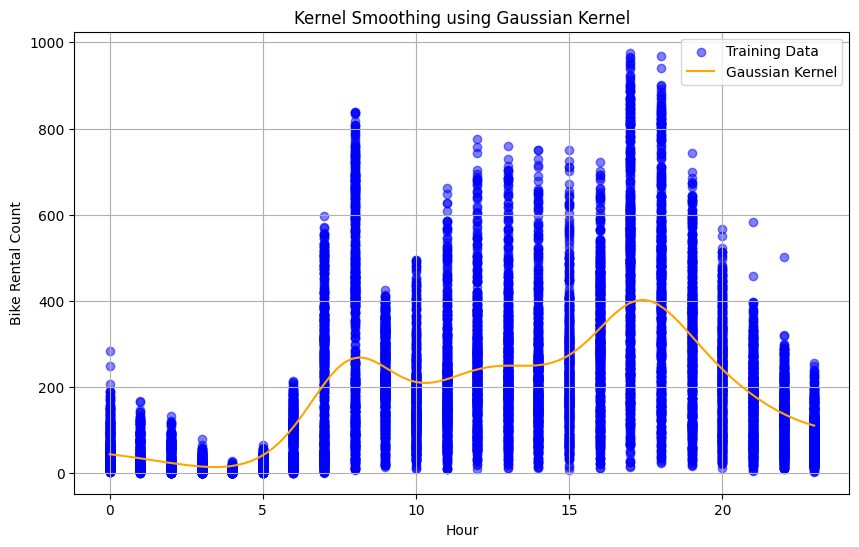

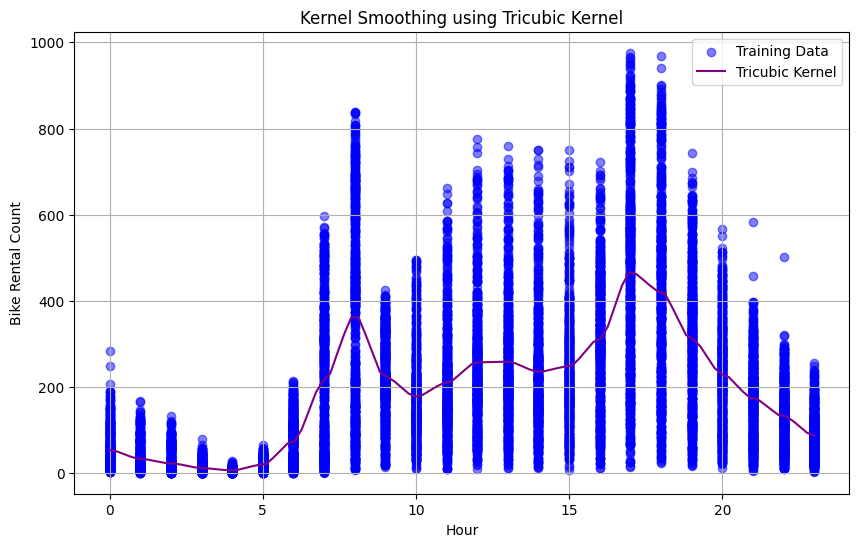

In [ ]:
lmbda = 1

# Create an array of temperature values for prediction
temp_values = np.linspace(X_trainHour['hr'].min(), X_trainHour['hr'].max(), 100).reshape(-1, 1)

# Predict using Epanechnikov kernel
y_pred_epanechnikov = np.array([knn_Epanechnikov(lmbda, point, X_trainHour['hr'], y_trainHour) for point in temp_values])

# Plot Epanechnikov kernel
plt.figure(figsize=(10, 6))
plt.scatter(X_trainHour['hr'], y_trainHour, label='Training Data', color='blue', alpha=0.5)
plt.plot(temp_values, y_pred_epanechnikov, label='Epanechnikov Kernel', color='green')
plt.xlabel('Hour')
plt.ylabel('Bike Rental Count')
plt.title('Kernel Smoothing using Epanechnikov Kernel')
plt.legend()
plt.grid(True)
plt.show()

print("\n")

# Predict using Gaussian kernel
y_pred_gaussian = np.array([knn_Gaussian(lmbda, point, X_trainHour['hr'], y_trainHour) for point in temp_values])

# Plot Gaussian kernel
plt.figure(figsize=(10, 6))
plt.scatter(X_trainHour['hr'], y_trainHour, label='Training Data', color='blue', alpha=0.5)
plt.plot(temp_values, y_pred_gaussian, label='Gaussian Kernel', color='orange')
plt.xlabel('Hour')
plt.ylabel('Bike Rental Count')
plt.title('Kernel Smoothing using Gaussian Kernel')
plt.legend()
plt.grid(True)
plt.show()

print("\n")

# Predict using Tricubic kernel
y_pred_tricubic = np.array([knn_Tricubic(lmbda, point, X_trainHour['hr'], y_trainHour) for point in temp_values])

# Plot Tricubic kernel
plt.figure(figsize=(10, 6))
plt.scatter(X_trainHour['hr'], y_trainHour, label='Training Data', color='blue', alpha=0.5)
plt.plot(temp_values, y_pred_tricubic, label='Tricubic Kernel', color='purple')
plt.xlabel('Hour')
plt.ylabel('Bike Rental Count')
plt.title('Kernel Smoothing using Tricubic Kernel')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
lmbda = 1

y_pred_epanechnikov_value = np.array(knn_Epanechnikov(lmbda, 17.5, X_trainHour['hr'], y_trainHour))
print(y_pred_epanechnikov_value)


444.0549828178694


Tomando en cuenta la humedad como $g/m^3$ sus unidades teniendo en cuenta que la información que nos da el dataset es que la normalizada es /100 para desnormalizarlo multiplicamos el valor por 100

Usando la función Knn_multi podemos hacer una predicción dado diferentes caracteristicas en el ejemplo usado podemos calcular cuantas bicicletas son rentadas dado que la temperatura es 9.6°C con sensación termica de 10.4°C y una humedad de 50.0 $g/m^3$

In [ ]:
def knn_multi(k: int, point: np.ndarray, data_x: np.ndarray, data_y: np.ndarray) -> float:
    distances = np.array([distance.euclidean(point, x) for x in data_x])

    idx_sorted = np.argsort(distances)[:k]

    return data_y[idx_sorted].mean()

X_train_subset = X_trainDay[['temp', 'atemp', 'hum']]
bike_features = pd.DataFrame({'temp': [.4], 'atemp': [.4], 'hum': [.5]})

y_pred_multi = np.array(knn_multi(100, bike_features.values.flatten(), X_train_subset.values, y_trainHour.values))
print("El numero de bicicletas rentadas cuando la temperatura tiene un valor de",desnormalize_min_max(bike_features['temp'].values,-8,36),"La sensación termica de",desnormalize_min_max(bike_features['atemp'].values,-16,50),"y la humedad de",.5*100,"es",y_pred_multi)


El numero de bicicletas rentadas cuando la temperatura tiene un valor de [9.6] La sensación termica de [10.4] y la humedad de 50.0 es 199.71
